**Financial Crisis Prediction using Macroeconomic Indicators – LSTM**<br>

**A Deep Learning Approach for Binary Recession Forecasting**

In [58]:
# -----------------------------
# Step 1: Import Required Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
# -----------------------------
# Step 2: Load Datasets
# -----------------------------
df = pd.read_csv('/content/current_2023-10_monthly.csv')
usrec_df = pd.read_csv('/content/USRECD.csv')

In [60]:
# -----------------------------
# Step 3: Clean and Convert Dates
# -----------------------------
df = df[df['sasdate'].str.match(r'^\d', na=False)]
df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y', errors='coerce')

usrec_df.rename(columns={'observation_date': 'sasdate'}, inplace=True)
usrec_df['sasdate'] = pd.to_datetime(usrec_df['sasdate'], format='%Y-%m-%d', errors='coerce')

# Filter for 2000-2023
df = df[(df['sasdate'] >= '2000-01-01') & (df['sasdate'] <= '2023-08-01')]

In [61]:
# -----------------------------
# Step 4: Merge with Recession Indicator
# -----------------------------
merged_df = pd.merge(df, usrec_df, on='sasdate', how='inner')
merged_df.fillna(method='ffill', inplace=True)
merged_df.rename(columns={'USRECD': 'target'}, inplace=True)

/tmp/ipython-input-430514684.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [62]:

# -----------------------------
# Step 5: Correlation-Based Feature Selection
# -----------------------------
cor_target = merged_df.corr(numeric_only=True)['target'].drop('target').sort_values(ascending=False)
top_features = cor_target.head(10).index.tolist()

print("Selected Top Features:\n", top_features)

Selected Top Features:
 ['VIXCLSx', 'BAA', 'S&P div yield', 'UEMPLT5', 'COMPAPFFx', 'BAAFFM', 'CLAIMSx', 'AAA', 'ISRATIOx', 'EXSZUSx']


In [63]:
def create_sequences(X, y, seq_length=12):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


In [64]:
forecast_horizon = 6  # months ahead

merged_df['target_future'] = merged_df['target'].shift(-forecast_horizon)

# Drop rows with NaN in the shifted column
merged_df.dropna(subset=['target_future'], inplace=True)

# Use the new target for your model
y_all = merged_df['target_future'].values
X_all = merged_df[top_features].values

X, y = create_sequences(X_all, y_all, seq_length=12)

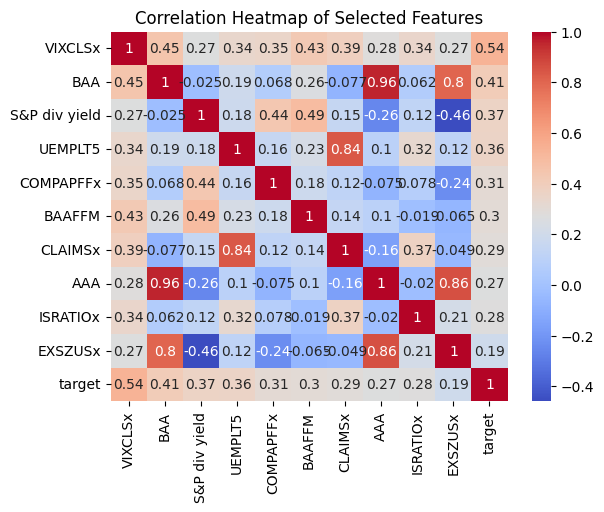

In [65]:
# Visualize Correlation
sns.heatmap(merged_df[top_features + ['target']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Selected Features")
plt.show()

In [66]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, column_name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Test for {column_name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  # Lags Used: {result[2]}")
    print(f"  # Observations Used: {result[3]}")
    if result[1] <= 0.05:
        print("  ➜ Stationary (Reject Null Hypothesis)")
    else:
        print("  ➜ Non-Stationary (Fail to Reject Null Hypothesis)")
    print("-" * 50)

# Run ADF test for each top feature and target
for col in top_features + ['target']:
    adf_test(merged_df[col], col)


ADF Test for VIXCLSx:
  Test Statistic: -4.0724
  p-value: 0.0011
  # Lags Used: 2
  # Observations Used: 275
  ➜ Stationary (Reject Null Hypothesis)
--------------------------------------------------
ADF Test for BAA:
  Test Statistic: -2.0384
  p-value: 0.2700
  # Lags Used: 2
  # Observations Used: 275
  ➜ Non-Stationary (Fail to Reject Null Hypothesis)
--------------------------------------------------
ADF Test for S&P div yield:
  Test Statistic: -3.2148
  p-value: 0.0191
  # Lags Used: 7
  # Observations Used: 270
  ➜ Stationary (Reject Null Hypothesis)
--------------------------------------------------
ADF Test for UEMPLT5:
  Test Statistic: -12.3971
  p-value: 0.0000
  # Lags Used: 0
  # Observations Used: 277
  ➜ Stationary (Reject Null Hypothesis)
--------------------------------------------------
ADF Test for COMPAPFFx:
  Test Statistic: -3.8470
  p-value: 0.0025
  # Lags Used: 10
  # Observations Used: 267
  ➜ Stationary (Reject Null Hypothesis)
----------------------------

In [67]:
forecast_horizon = 6  # months ahead

merged_df['target_future'] = merged_df['target'].shift(-forecast_horizon)

# Drop rows with NaN in the shifted column
merged_df.dropna(subset=['target_future'], inplace=True)

# Use the new target for your model
y_all = merged_df['target_future'].values
X_all = merged_df[top_features].values

X, y = create_sequences(X_all, y_all, seq_length=12)


In [68]:
# -----------------------------
# Step 6: Scale the Features
# -----------------------------
features_df = merged_df[top_features]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_df)

# Combine with target
final_df = pd.DataFrame(scaled_features, columns=top_features)
final_df['target'] = merged_df['target'].values

In [69]:
# -----------------------------
# Step 7: Create Time Series Sequences
# -----------------------------
def create_sequences(X, y, seq_length=12):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_all = final_df[top_features].values
y_all = final_df['target'].values
X, y = create_sequences(X_all, y_all, seq_length=12)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (260, 12, 10)
y shape: (260,)


In [70]:
# -----------------------------
# Step 8: Train-Test Split
# -----------------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [71]:

# -----------------------------
# Step 9: Compute Class Weights (Optional but Recommended)
# -----------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [72]:
from imblearn.over_sampling import SMOTE

X_2d = X.reshape(X.shape[0], -1)  # Flatten for SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_2d, y)

# Reshape back to 3D for LSTM
X_bal = X_bal.reshape(X_bal.shape[0], 12, X.shape[2])

# Train-test split on balanced data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)


In [73]:
class_weights_dict = {0: 1, 1: 20}  # Try giving 10x or 20x more weight to class 1


In [74]:

# -----------------------------
# Step 10: Build the LSTM Model
# -----------------------------

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2]), dropout=0.3, recurrent_dropout=0.3),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt_0 = 1 - pt_1
        return -K.mean(alpha * K.pow(1 - pt_1, gamma) * y_true * K.log(pt_1) +
                       (1 - alpha) * K.pow(1 - pt_0, gamma) * (1 - y_true) * K.log(pt_0))
    return focal_loss_fixed

model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# -----------------------------
# Step 11: Train the Model
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.5158 - loss: 0.8246 - val_accuracy: 0.4933 - val_loss: 0.0677
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5571 - loss: 0.7173 - val_accuracy: 0.6533 - val_loss: 0.0568
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6490 - loss: 0.6397 - val_accuracy: 0.6400 - val_loss: 0.0524
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6829 - loss: 0.5970 - val_accuracy: 0.6533 - val_loss: 0.0511
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6717 - loss: 0.5564 - val_accuracy: 0.8933 - val_loss: 0.0497
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7145 - loss: 0.5382 - val_accuracy: 0.7467 - val_loss: 0.0455
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7833 - loss: 0.4649 - val_accuracy: 0.8667 - val_loss: 0.0448
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6844 - loss: 0.5220 - val_accuracy: 

In [77]:
import gradio as gr
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
model.save("recession_lstm.h5")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

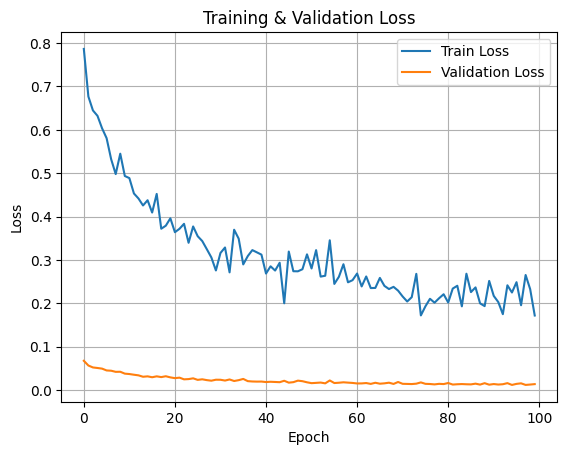

In [78]:
# -----------------------------
# Step 12: Plot Training History
# -----------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
AUC: 0.996299722479186


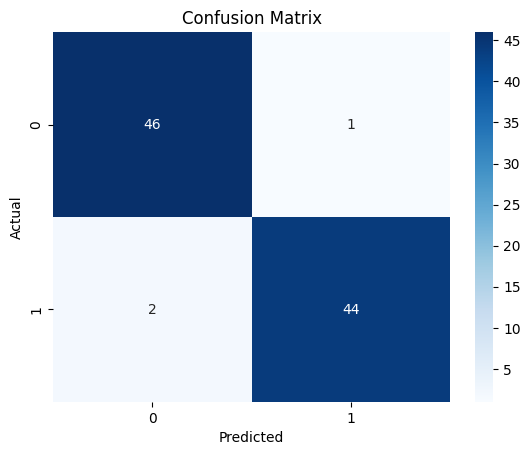

In [79]:
# -----------------------------
# Step 13: Evaluate the Model
# -----------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# print("Classification Report:\n")
# print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_prob))


# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

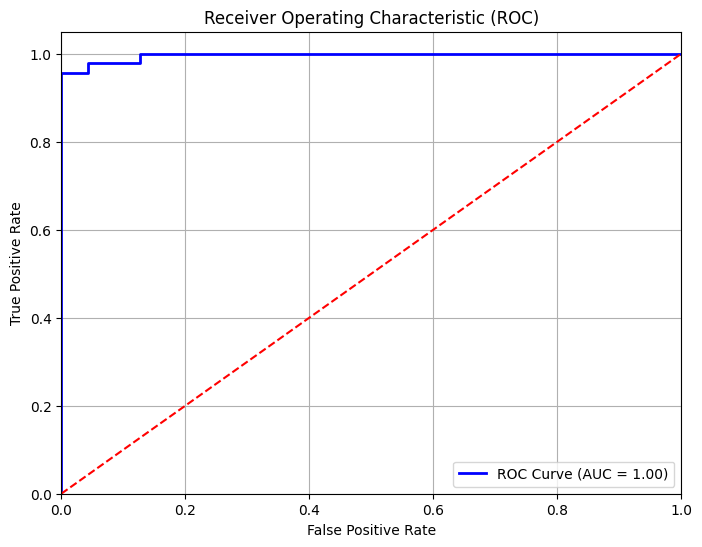

In [80]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [81]:
# -----------------------------
# Step 14: Test with Hardcoded Examples
# -----------------------------

# Example 1 - Recession-like feature values (scaled)
# NOTE: These values should be in the same scale as the MinMaxScaler used earlier.
# If you want realistic numbers, take a row from your dataset known to be recession = 1
example_recession = np.array([
    scaled_features[10:22]  # 12 months sequence from an actual recession period
])

# Example 2 - Non-recession-like feature values (scaled)
# Pick a period where target=0
example_non_recession = np.array([
    scaled_features[100:112]  # 12 months sequence from a stable period
])

# Stack examples for testing
examples = np.vstack([example_recession, example_non_recession])
print("Example input shape:", examples.shape)

# Predict probabilities
pred_probs = model.predict(examples)
pred_classes = (pred_probs > 0.5).astype(int)

# Display results
labels_map = {0: "Non-Recession", 1: "Recession"}
for i, pred in enumerate(pred_classes):
    print(f"Example {i+1} -> Predicted: {labels_map[int(pred)]} (Prob: {pred_probs[i][0]:.4f})")


Example input shape: (2, 12, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Example 1 -> Predicted: Recession (Prob: 0.5835)
Example 2 -> Predicted: Recession (Prob: 0.6566)


/tmp/ipython-input-3138605321.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Example {i+1} -> Predicted: {labels_map[int(pred)]} (Prob: {pred_probs[i][0]:.4f})")


In [82]:
# -----------------------------
# Load model and scaler
# -----------------------------
model = load_model("recession_lstm.h5", compile=False)  # trained LSTM saved earlier
scaler = joblib.load("scaler.pkl")  # save your MinMaxScaler after training

# -----------------------------
# Prediction function
# -----------------------------
def predict_recession(*inputs):
    # Inputs come as flat list: 12 months × 10 features
    arr = np.array(inputs).reshape(12, 10)  # 12 timesteps, 10 features
    arr_scaled = scaler.transform(arr)      # scale using training scaler
    arr_scaled = arr_scaled.reshape(1, 12, 10)  # batch dimension
    prob = model.predict(arr_scaled)[0][0]
    label = "Recession" if prob > 0.5 else "Non-Recession"
    return f"{label} (prob={prob:.3f})"

# -----------------------------
# Build Gradio UI
# -----------------------------
feature_names = [f"Feature {i+1}" for i in range(10)]
inputs_list = []
for month in range(1, 13):
    for feat in feature_names:
        inputs_list.append(gr.Number(label=f"{feat} - Month {month}"))

demo = gr.Interface(
    fn=predict_recession,
    inputs=inputs_list,
    outputs="text",
    title="Recession Predictor (LSTM)",
    description="Enter 10 feature values for 12 consecutive months to classify as Recession or Non-Recession."
)

if __name__ == "__main__":
    demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2fa097d4dc9dbe6ee0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
